In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_csv('car_fuel_efficiency.txt')
df = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]

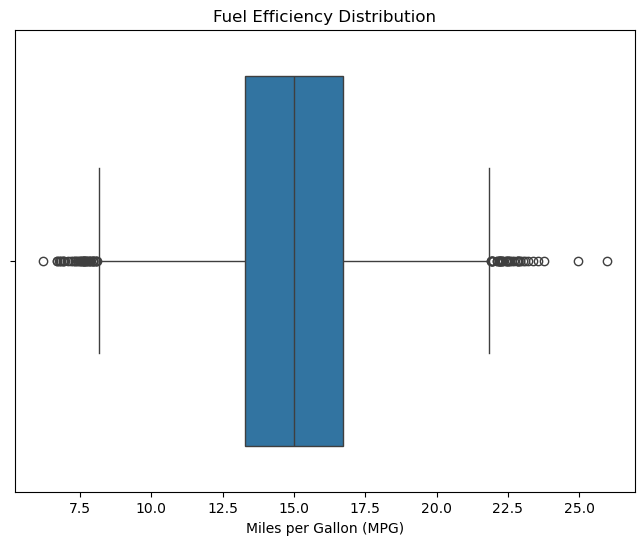

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df.fuel_efficiency_mpg)
plt.title('Fuel Efficiency Distribution')
plt.xlabel('Miles per Gallon (MPG)')
plt.show()

In [38]:
print('column with null values:', df.isnull().sum().sort_values(ascending=False).index[1])
print('median value for horsepower is:',df.horsepower.median())

column with null values: engine_displacement
median value for horsepower is: 149.0


In [86]:
def splitting(df, seed=np.random.seed(42)):

    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()


    y_train_orig = df_train.fuel_efficiency_mpg.values
    y_val_orig = df_val.fuel_efficiency_mpg.values
    y_test_orig = df_test.fuel_efficiency_mpg.values

    y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
    y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
    y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    return df_train, df_val, df_test, y_train, y_val, y_test, y_train_orig, y_val_orig, y_test_orig

df_train, df_val, df_test, y_train, y_val, y_test, y_train_orig, y_val_orig, y_test_orig = splitting(df)

In [134]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]


def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)


def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]



base = list(df_train.columns)

In [87]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

print('rmse for fill with 0 is:',rmse(y_train, y_pred))


rmse for fill with 0 is: 0.0390863253926525


In [56]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(df_num.mean())
    X = df_num.values
    return X

X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

print('rmse for fill with mean is:',rmse(y_train, y_pred))


rmse for fill with mean is: 0.035810837859002305


In [83]:
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_train.dot(w)
    print('%5s, %2s' % (r, round(rmse(y_train, y_pred), 3)))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('rmse:',round(rmse(y_val, y_pred),2))


    0, 0.039
0.001, 0.039
 0.01, 0.039
  0.1, 0.04
    1, 0.041
   10, 0.041
rmse: 0.04


In [121]:
rmse_list = []

for i in range(10):
    df_train, df_val, df_test, y_train, y_val, y_test, y_train_orig, y_val_orig, y_test_orig = splitting(df, seed=i)
    X_train = prepare_X(df_train)
    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_train.dot(w)

    rmse_list.append(rmse(y_train, y_pred))

rmse_mean = np.mean(rmse_list)
rmse_std = np.std(rmse_list)
print(round(rmse_std,4))


0.0003


In [131]:
df_train, df_val, df_test, y_train, y_val, y_test, y_train_orig, y_val_orig, y_test_orig = splitting(df, seed=9)

train_data = pd.concat([df_train, df_val])
y_train_new = np.concatenate([y_train, y_val])



X_train = prepare_X(train_data)
w_0, w = train_linear_regression_reg(X_train, y_train_new, r=0.001)

y_pred = w_0 + df_test.dot(w)
round(rmse(y_test, y_pred), 3)

np.float64(0.038)